# EDA и ресерч-анализ

## Импорт всех необходимых библиотек.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Загрузка и предобработка данных

In [2]:
df = pd.read_csv("titanic.csv")
print("Пропущенные значения:\n", df.isnull().sum())

df['Age'] = df['Age'].fillna(df['Age'].median())
df['Cabin'] = df['Cabin'].fillna('Unknown')

Пропущенные значения:
 PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


## Описательная статистика и распределение возраста пассажиров

Статистика данных:
        PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  891.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.361582    0.523008   
std     257.353842    0.486592    0.836071   13.019697    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000   22.000000    0.000000   
50%     446.000000    0.000000    3.000000   28.000000    0.000000   
75%     668.500000    1.000000    3.000000   35.000000    1.000000   
max     891.000000    1.000000    3.000000   80.000000    8.000000   

            Parch        Fare  
count  891.000000  891.000000  
mean     0.381594   32.204208  
std      0.806057   49.693429  
min      0.000000    0.000000  
25%      0.000000    7.910400  
50%      0.000000   14.454200  
75%      0.000000   31.000000  
max      6.000000  512.329200  


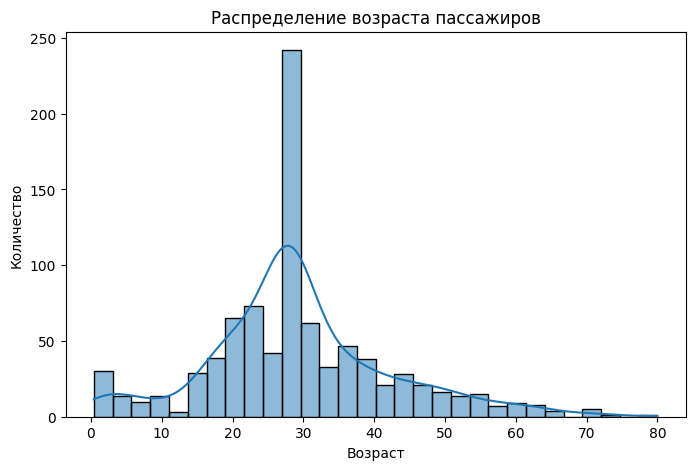

In [3]:
print("Статистика данных:\n", df.describe())

plt.figure(figsize=(8,5))
sns.histplot(df['Age'], bins=30, kde=True)
plt.title("Распределение возраста пассажиров")
plt.xlabel("Возраст")
plt.ylabel("Количество")
plt.show()

## Корреляция колонок с Survived

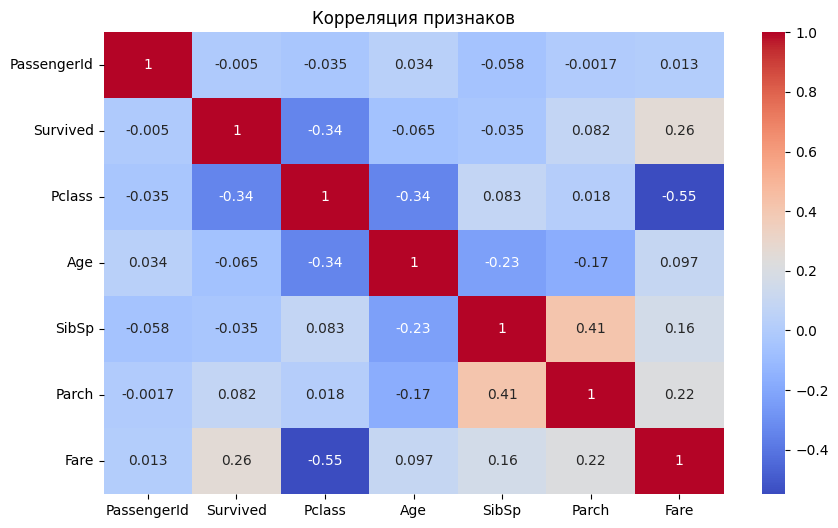

In [4]:
numeric_df = df.select_dtypes(include=['number'])

plt.figure(figsize=(10,6))
sns.heatmap(numeric_df.corr(), annot=True, cmap="coolwarm")
plt.title("Корреляция признаков")
plt.show()

## Анализ влияния пола на выживаемость

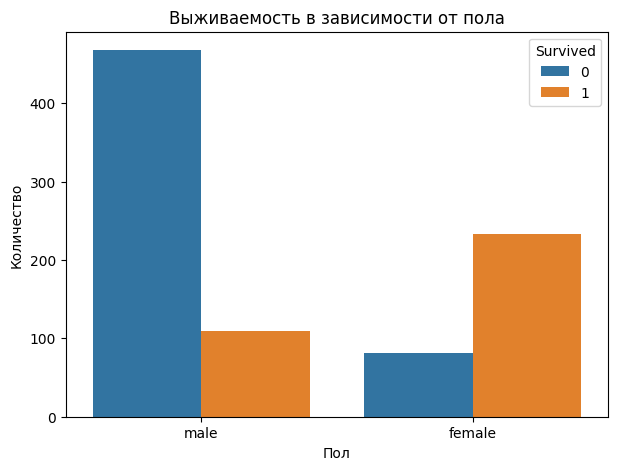

In [5]:
plt.figure(figsize=(7,5))
sns.countplot(data=df, x="Sex", hue="Survived")
plt.title("Выживаемость в зависимости от пола")
plt.xlabel("Пол")
plt.ylabel("Количество")
plt.show()

# Feature Engineering

## Обработка категориальных признаков

In [6]:
from sklearn.preprocessing import LabelEncoder

# Преобразование пола в числовой формат (0 - male, 1 - female)
df['Sex_encoded'] = LabelEncoder().fit_transform(df['Sex'])

# Преобразование порта посадки (заполняем пропуски самым частым значением 'S')
df['Embarked'] = df['Embarked'].fillna('S')
df['Embarked_encoded'] = LabelEncoder().fit_transform(df['Embarked'])

# Извлечение информации из каюты (первая буква обозначает палубу)
df['Deck'] = df['Cabin'].apply(lambda x: x[0] if x != 'Unknown' else 'U')
df['Deck_encoded'] = LabelEncoder().fit_transform(df['Deck'])

## Создание новых признаков

In [7]:
# Семейные признаки
df['FamilySize'] = df['SibSp'] + df['Parch'] + 1  # Общий размер семьи
df['IsAlone'] = (df['FamilySize'] == 1).astype(int)  # Путешествует один

# Признаки на основе имени (извлечение титула)
df['Title'] = df['Name'].str.extract(r' ([A-Za-z]+)\.', expand=False)
df['Title'] = df['Title'].replace(['Lady', 'Countess','Capt', 'Col', 'Don', 'Dr', 
                                   'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
df['Title'] = df['Title'].replace('Mlle', 'Miss')
df['Title'] = df['Title'].replace('Ms', 'Miss')
df['Title'] = df['Title'].replace('Mme', 'Mrs')
df['Title_encoded'] = LabelEncoder().fit_transform(df['Title'])

# Признаки на основе возраста
df['AgeBin'] = pd.cut(df['Age'], bins=[0, 12, 18, 35, 60, 100], labels=[1, 2, 3, 4, 5]).astype(float)
df['IsChild'] = (df['Age'] < 16).astype(int)

# Признаки на основе цены билета
df['FareBin'] = pd.qcut(df['Fare'], 4, labels=[1, 2, 3, 4]).astype(float)
df['FarePerPerson'] = df['Fare'] / df['FamilySize']

## Анализ новых признаков

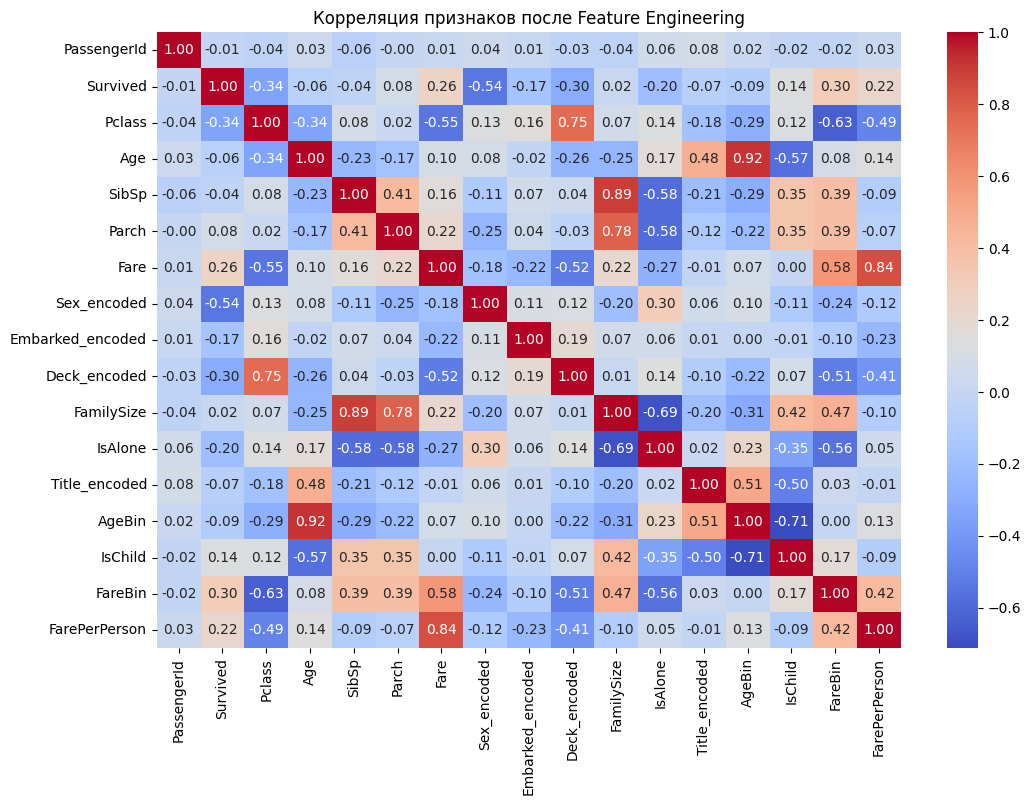

Корреляция признаков с целевой переменной Survived:
FareBin          0.299357
Fare             0.257307
FarePerPerson    0.221600
IsChild          0.136107
Parch            0.081629
FamilySize       0.016639
PassengerId     -0.005007
SibSp           -0.035322
Age             -0.064910
Title_encoded   -0.071174
Name: Survived, dtype: float64


In [8]:
new_features = ['FamilySize', 'IsAlone', 'Title_encoded', 'AgeBin', 'IsChild', 'FareBin', 'FarePerPerson', 'Deck_encoded']
numeric_df = df.select_dtypes(include=['number'])

plt.figure(figsize=(12,8))
sns.heatmap(numeric_df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Корреляция признаков после Feature Engineering")
plt.show()

corr_with_target = numeric_df.corr()['Survived'].sort_values(ascending=False)
print("Корреляция признаков с целевой переменной Survived:")
print(corr_with_target[1:11]) 

## Визуализация новых признаков

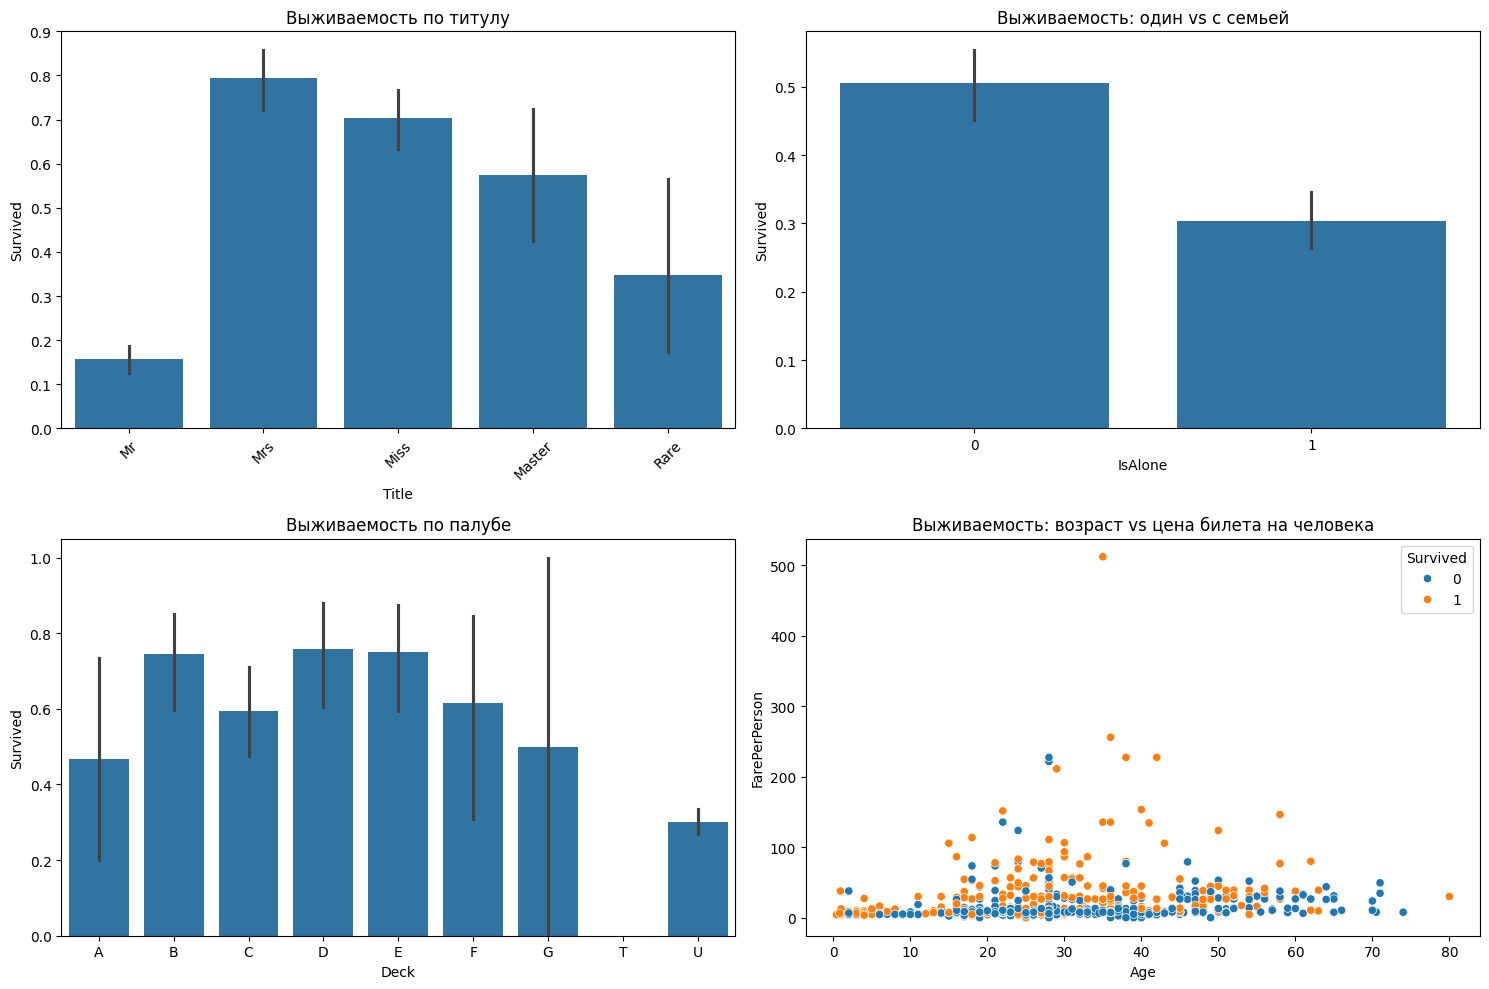

In [9]:
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
sns.barplot(x='Title', y='Survived', data=df)
plt.title('Выживаемость по титулу')
plt.xticks(rotation=45)

plt.subplot(2, 2, 2)
sns.barplot(x='IsAlone', y='Survived', data=df)
plt.title('Выживаемость: один vs с семьей')

plt.subplot(2, 2, 3)
sns.barplot(x='Deck', y='Survived', data=df, order=sorted(df['Deck'].unique()))
plt.title('Выживаемость по палубе')

plt.subplot(2, 2, 4)
sns.scatterplot(x='Age', y='FarePerPerson', hue='Survived', data=df)
plt.title('Выживаемость: возраст vs цена билета на человека')

plt.tight_layout()
plt.show()

## Feature Selection

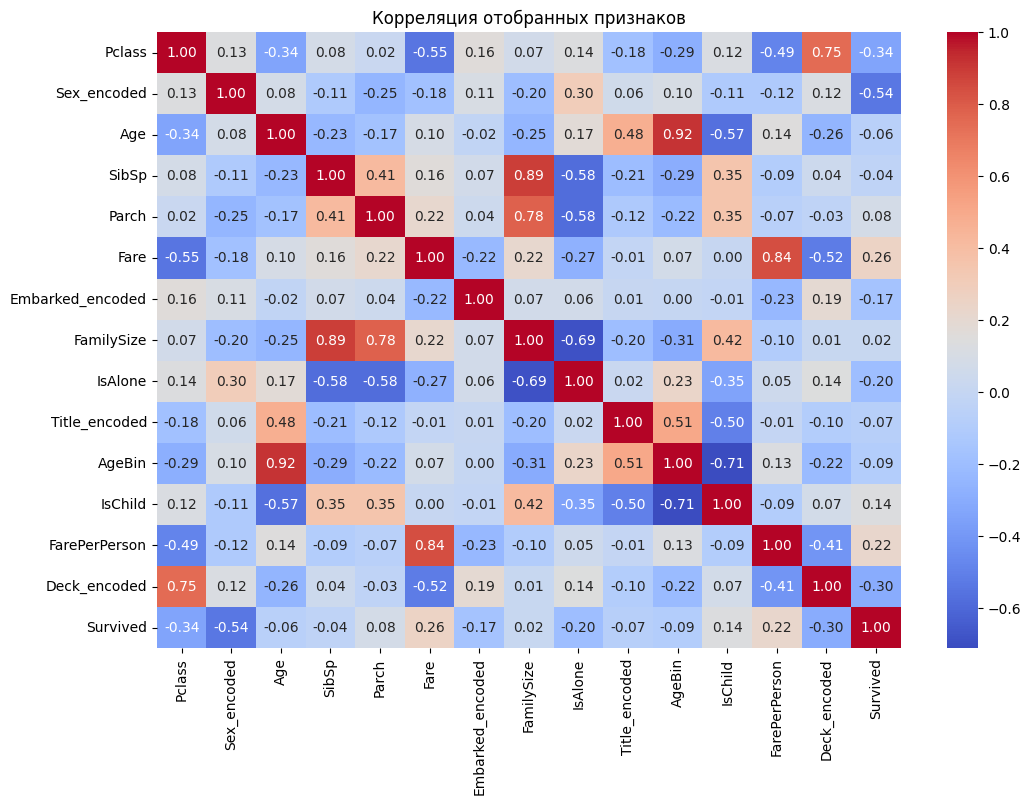

In [10]:
selected_features = [
    'Pclass',
    'Sex_encoded',
    'Age',
    'SibSp',
    'Parch',
    'Fare',
    'Embarked_encoded',
    'FamilySize',
    'IsAlone',
    'Title_encoded',
    'AgeBin',
    'IsChild',
    'FarePerPerson',
    'Deck_encoded'
]

df_engineered = df[selected_features + ['Survived']].copy()

plt.figure(figsize=(12,8))
sns.heatmap(df_engineered.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Корреляция отобранных признаков")
plt.show()

# Эксперименты

### Линейная модель машинного обучения

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

data = pd.read_csv("Titanic.csv")

target = 'Survived'
features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
X = data[features]
y = data[target]

tnumeric = ['Age', 'SibSp', 'Parch', 'Fare']
numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

tcategorical = ['Pclass', 'Sex', 'Embarked']
categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numeric_pipeline, tnumeric),
    ('cat', categorical_pipeline, tcategorical)
])

model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(f'Accuracy: {accuracy_score(y_test, y_pred):.3f}')
print('Classification Report:\n', classification_report(y_test, y_pred))

feature_names = model.named_steps['preprocessor'].get_feature_names_out()
coefficients = model.named_steps['classifier'].coef_[0]

coef_df = pd.DataFrame({
    'feature': feature_names,
    'coefficient': coefficients
}).sort_values(by='coefficient', ascending=False)

print('Coefficients:\n', coef_df)


Accuracy: 0.804
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.89      0.85       110
           1       0.79      0.67      0.72        69

    accuracy                           0.80       179
   macro avg       0.80      0.78      0.79       179
weighted avg       0.80      0.80      0.80       179

Coefficients:
             feature  coefficient
7   cat__Sex_female     1.364351
4     cat__Pclass_1     1.038653
10  cat__Embarked_Q     0.348068
5     cat__Pclass_2     0.138022
3         num__Fare     0.133851
9   cat__Embarked_C     0.095733
2        num__Parch    -0.070794
1        num__SibSp    -0.261398
11  cat__Embarked_S    -0.321817
0          num__Age    -0.489323
6     cat__Pclass_3    -1.054692
8     cat__Sex_male    -1.242368


### Деревья

Accuracy: 0.78


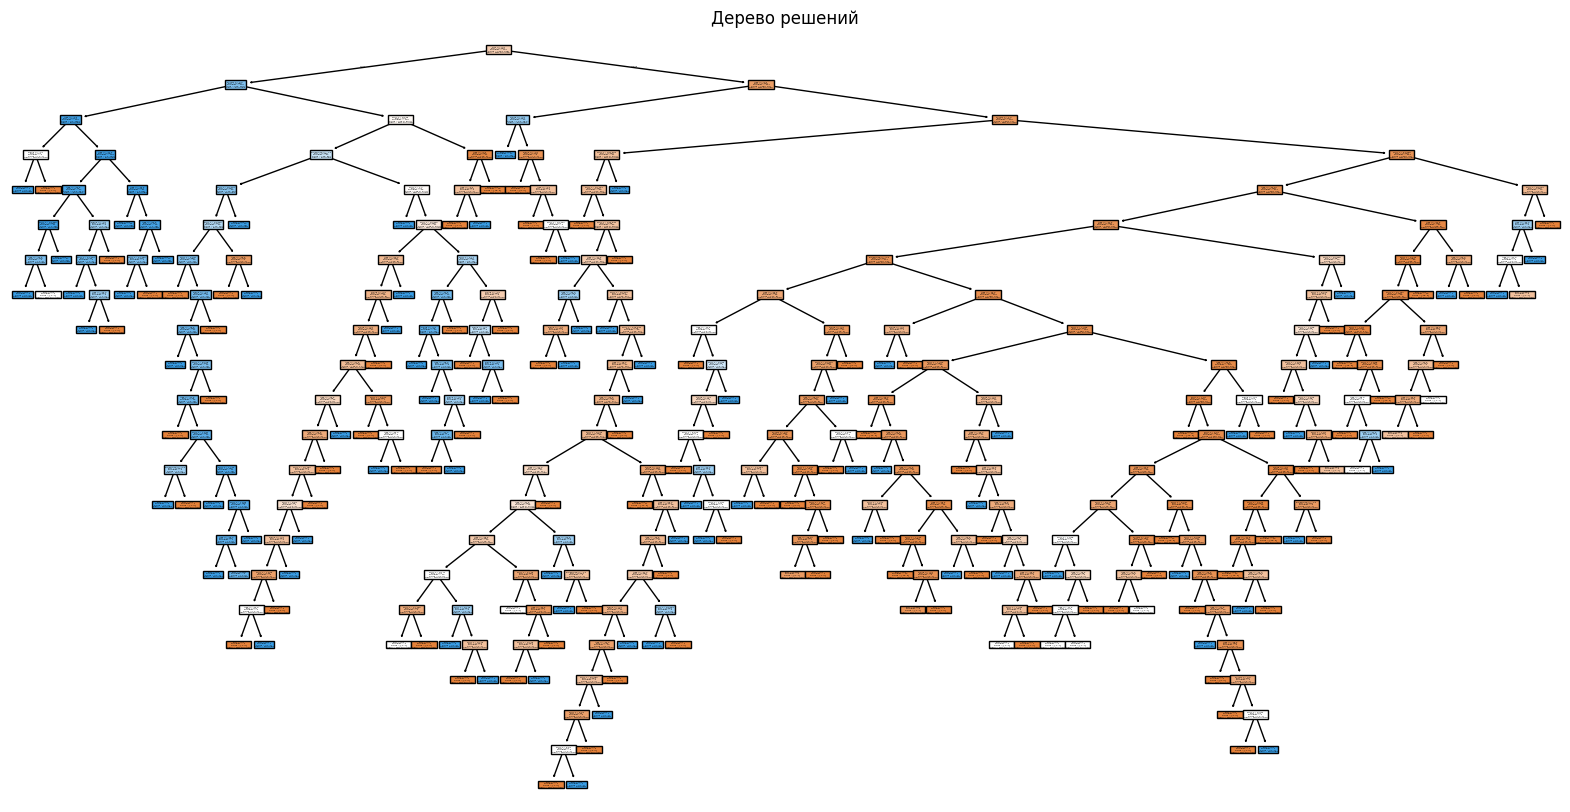

In [12]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

df = pd.read_csv('titanic.csv')

df = df[['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']]

df['Age'] = df['Age'].fillna(df['Age'].median())
df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])

le_sex = LabelEncoder()
le_embarked = LabelEncoder()
df['Sex'] = le_sex.fit_transform(df['Sex'])
df['Embarked'] = le_embarked.fit_transform(df['Embarked'])

X = df.drop('Survived', axis=1)
y = df['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = DecisionTreeClassifier(random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

plt.figure(figsize=(20, 10))
plot_tree(model, feature_names=X.columns, class_names=['Not Survived', 'Survived'], filled=True)
plt.title("Дерево решений")
plt.show()


### Градиентный бустинг

In [13]:
import xgboost as xgb
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split

# Используем уже подготовленные признаки
X = df_engineered.drop('Survived', axis=1)
y = df_engineered['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

model_xgb = xgb.XGBClassifier(eval_metric='logloss',random_state=42)
model_xgb.fit(X_train, y_train)

y_pred = model_xgb.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}")
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.810
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.86      0.85       110
           1       0.77      0.72      0.75        69

    accuracy                           0.81       179
   macro avg       0.80      0.79      0.80       179
weighted avg       0.81      0.81      0.81       179



### Нейронная сеть

In [14]:
from sklearn.neural_network import MLPClassifier

data = pd.read_csv("Titanic.csv")

target = 'Survived'
features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
X = data[features]
y = data[target]

numeric_features = ['Age', 'SibSp', 'Parch', 'Fare']
numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_features = ['Pclass', 'Sex', 'Embarked']
categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numeric_pipeline, numeric_features),
    ('cat', categorical_pipeline, categorical_features)
])

model_nn = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', MLPClassifier(
        hidden_layer_sizes=(50, 30), 
        activation='relu',
        max_iter=500,
        random_state=42,
        early_stopping=True,
        validation_fraction=0.1
    ))
])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

model_nn.fit(X_train, y_train)
y_pred = model_nn.predict(X_test)

print(f'Neural Network Accuracy: {accuracy_score(y_test, y_pred):.3f}')
print('Classification Report:\n', classification_report(y_test, y_pred))

Neural Network Accuracy: 0.793
Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.94      0.85       110
           1       0.85      0.57      0.68        69

    accuracy                           0.79       179
   macro avg       0.81      0.75      0.76       179
weighted avg       0.80      0.79      0.78       179



### Сравнение моделей

Logistic Regression:
  Средняя точность: 0.797 (±0.015)
  Все результаты: [0.782 0.803 0.798 0.781 0.82 ]

Decision Tree:
  Средняя точность: 0.784 (±0.024)
  Все результаты: [0.804 0.809 0.747 0.764 0.798]

XGBoost:
  Средняя точность: 0.814 (±0.025)
  Все результаты: [0.832 0.809 0.77  0.815 0.843]

Neural Network:
  Средняя точность: 0.799 (±0.014)
  Все результаты: [0.782 0.787 0.803 0.82  0.803]



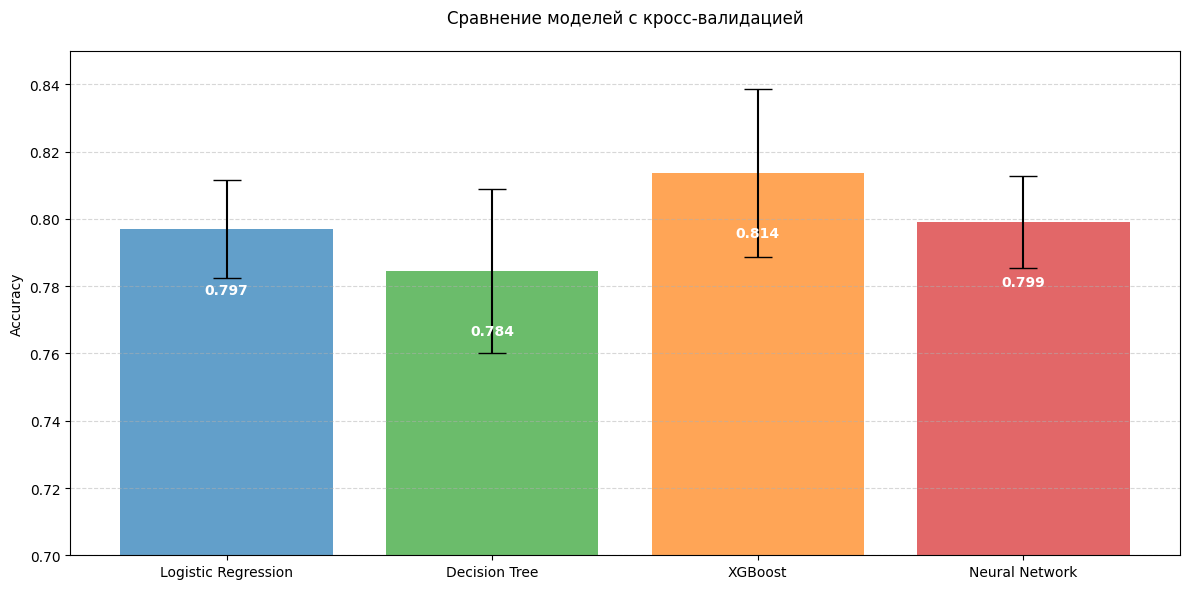


Лучшая модель: XGBoost (средняя точность: 0.814)


In [16]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

models = {
    'Logistic Regression': Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(max_iter=1000, random_state=42))
    ]),
    'Decision Tree': Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', DecisionTreeClassifier(random_state=42))
    ]),
    'XGBoost': Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', XGBClassifier(eval_metric='logloss', random_state=42))
    ]),
    'Neural Network': model_nn  # Используем уже созданную модель нейросети
}

# Настройка кросс-валидации
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = {}

# Выполнение кросс-валидации для всех моделей
for name, model in models.items():
    scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy', n_jobs=-1)
    results[name] = {
        'mean_accuracy': np.mean(scores),
        'std_accuracy': np.std(scores),
        'all_scores': scores
    }
    print(f"{name}:")
    print(f"  Средняя точность: {results[name]['mean_accuracy']:.3f} (±{results[name]['std_accuracy']:.3f})")
    print(f"  Все результаты: {np.round(results[name]['all_scores'], 3)}\n")

# Визуализация результатов
plt.figure(figsize=(12, 6))
x = np.arange(len(models))
means = [results[name]['mean_accuracy'] for name in models]
stds = [results[name]['std_accuracy'] for name in models]

bars = plt.bar(x, means, yerr=stds, align='center', alpha=0.7, 
               color=['#1f77b4', '#2ca02c', '#ff7f0e', '#d62728'], capsize=10)

plt.xticks(x, models.keys())
plt.ylabel('Accuracy')
plt.title('Сравнение моделей с кросс-валидацией', pad=20)
plt.ylim(0.7, 0.85)

# Добавление значений точности на столбцы
for bar, mean in zip(bars, means):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height - 0.02,
             f'{mean:.3f}',
             ha='center', va='bottom',
             color='white', fontweight='bold')

plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Определение лучшей модели
best_model_name = max(results, key=lambda x: results[x]['mean_accuracy'])
print(f"\nЛучшая модель: {best_model_name} (средняя точность: {results[best_model_name]['mean_accuracy']:.3f})")